# LegacyHalos SersicFitting

This notebook demonstrates how we fit the 1D surface brightness profiles using various parametric (e.g., Sersic) models, using one galaxy as a toy example.

### Imports, paths, and other preliminaries.

In [3]:
import os, pdb
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from legacyhalos import io
from legacyhalos.util import ellipse_sbprofile
from legacyhalos.qa import display_ellipse_sbprofile

In [5]:
plt.style.use('seaborn-talk')
%matplotlib inline

In [6]:
pixscale = 0.262
band = ('g', 'r', 'z')
refband = 'r'

### Define a wavelength-dependent Sersic model

In [10]:
from astropy.modeling import Fittable2DModel

In [26]:
def sb2flux(sb):
    """Convert surface brightness to linear flux."""
    return np.array([10**(-0.4 * _sb) for _sb in np.atleast_1d(sb)])

In [129]:
class SersicWaveModel(Fittable2DModel):
    """
    Define a surface brightness profile model which is the sum of three Sersic
    models connected by a Sersic index and half-light radius which varies
    as a power-law function of wavelength.
    
    See http://docs.astropy.org/en/stable/modeling/new.html#a-full-example-of-a-linemodel
    for a comparable example.
    
    ToDo: convolve the model with the PSF.

    """
    from astropy.modeling import Parameter
    
    nref = Parameter(default=4, min=0.1, max=8)
    r50ref = Parameter(default=10, min=1e-3) # [kpc]
    alpha = Parameter(default=0.0, min=-1, max=1)
    beta = Parameter(default=0.0, min=-1, max=1)
    mu50_g = Parameter(default=0.5) # [flux units]
    mu50_r = Parameter(default=1)
    mu50_z = Parameter(default=1.5)

    linear = False
    
    def __init__(self, nref=nref.default, r50ref=r50ref.default, 
                 alpha=alpha.default, beta=beta.default, mu50_g=mu50_g.default, 
                 mu50_r=mu50_r.default, mu50_z=mu50_z.default, lambda_ref=6470, 
                 lambda_g=4890, lambda_r=6470, lambda_z=9196, **kwargs):

        self.lambda_ref = lambda_ref
        self.lambda_g = lambda_g
        self.lambda_r = lambda_r
        self.lambda_z = lambda_z

        super(SersicWaveModel, self).__init__(nref=nref, r50ref=r50ref, alpha=alpha, 
                                              beta=beta, mu50_g=mu50_g, mu50_r=mu50_r, 
                                              mu50_z=mu50_z, **kwargs)
    
    def evaluate(self, r, w, nref, r50ref, alpha, beta, mu50_g, mu50_r, mu50_z):
        """Evaluate the wavelength-dependent Sersic model.
        
        Args:
          r : radius [kpc]
          w : wavelength [Angstrom]
          nref : Sersic index at the reference wavelength lambda_ref
          r50ref : half-light radius at lambda_ref
          alpha : power-law slope for the Sersic index
          beta : power-law slope for the half-light radius
          mu50_g : g-band surface brignthess at r=r50_g
          mu50_r : r-band surface brignthess at r=r50_r
          mu50_z : z-band surface brignthess at r=r50_z
        
        """
        
        from scipy.special import gammaincinv

        mu = np.zeros_like(r)
        
        # Build the surface brightness profile at each wavelength.
        for lam, mu50 in zip( (self.lambda_g, self.lambda_r, self.lambda_z), (mu50_g, mu50_r, mu50_z) ):
            
            n = nref * (lam / self.lambda_ref)**alpha
            r50 = r50ref * (lam / self.lambda_ref)**beta
        
            mu += mu50 * ( np.exp(-gammaincinv(2 * n, 0.5) * ((r / r50) ** (1 / n) - 1)) * (w == lam) )
        
        return mu

#### Simulate a data set

Create a "galaxy" with a g-, r-, and z-band surface brightness profile measured over different radii.  Choose the Sersic index to vary with wavelength as $\beta=0.1$ with $n_{ref}=2.8$, and the half-light radius to vary as $\alpha=-0.2$ with $r_{ref}=8$ kpc.

In [130]:
def plot_sbwave(radius, wave, sbwave, model=None):
    """Plot a wavelength-dependent surface brightness profile.

    nradii_per_band is the number of radius/SB measurements per bandpass, assumed
      to be sorted from (g, r, z).
    """

    if model:
        filtlambda = (model.lambda_g, model.lambda_r, model.lambda_z)
    else:
        filtlambda = np.sort(np.unique(wave))
    
    fig, ax = plt.subplots()
    for band, lam in zip( ('g', 'r', 'z'), filtlambda ):

        good = lam == wave
        rad = radius[good]
        sb = sbwave[good]

        srt = np.argsort(rad)
        rad, sb = rad[srt], sb[srt]
        ax.plot(rad, 22.5-2.5*np.log10(sb), label=band)
        
        # overplot the model
        if model:
            sb_model = model(rad, wave[good][srt])
            ax.plot(rad, 22.5-2.5*np.log10(sb_model), color='k', ls='--', alpha=0.5)
            
        ax.invert_yaxis()

    #ax.set_yscale('log')
    ax.legend(loc='upper right')

Model: SersicWaveModel
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
    nref r50ref alpha beta mu50_g mu50_r mu50_z
    ---- ------ ----- ---- ------ ------ ------
     2.8    8.0  -0.2  0.1    0.5    1.0    1.5


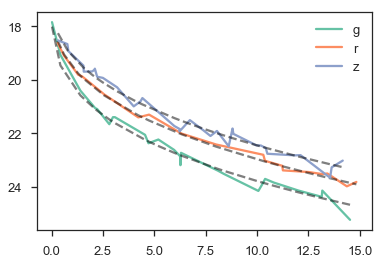

In [145]:
model = SersicWaveModel(beta=0.1, alpha=-0.2, r50ref=8, nref=2.8)
print(model)

seed = 1
rand = np.random.RandomState(seed)

minradius = 0.02
maxradius = 15.0
nrad = (25, 18, 33) # number of measurements per bandpass g, r, z

radius = []
wave = []
for lam, nn in zip( (model.lambda_g, model.lambda_r, model.lambda_z), nrad ):
    rad = rand.uniform(minradius, maxradius, nn)
    #rad = np.linspace(0, maxradius, nn)
    radius.append(rad)
    wave.append(np.repeat(lam, nn))
radius = np.hstack(radius)
wave = np.hstack(wave)
sb = model(radius, wave) # evaluate the model 
sberr = rand.normal(loc=0, scale=sb*0.2)
sb += sberr

# plot it!
plot_sbwave(radius, wave, sb, model=model)
#plt.axvline(x=8)
#plt.axhline(y=1)

Model: SersicWaveModel
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
    nref r50ref alpha beta mu50_g mu50_r mu50_z
    ---- ------ ----- ---- ------ ------ ------
     4.0   10.0   0.0  0.0    0.5    1.0    1.5
Model: SersicWaveModel
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
         nref        r50ref        alpha      ...     mu50_r        mu50_z   
    ------------- ------------ -------------- ... ------------- -------------
    2.80974667751 8.0085624503 -0.21881315472 ... 1.01310644581 1.52587659728


{'alpha': 0.12437106668215761,
 'beta': 0.1192009849171325,
 'mu50_g': 0.046716573754272926,
 'mu50_r': 0.062011373700041429,
 'mu50_z': 0.15063687104111073,
 'nref': 0.091310597295755982,
 'r50ref': 0.24039164687915629}

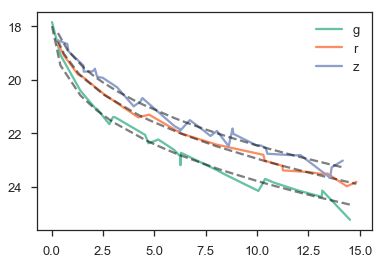

In [153]:
from astropy.modeling import fitting
#fixed = {'beta': True, 'alpha': True}
fixed = {}

sersicwave_init = SersicWaveModel() # beta=0.1, alpha=-0.2, r50ref=8, nref=2.8, fixed=fixed)

sersicwave_fit = fitting.LevMarLSQFitter()
sersicwave_best = sersicwave_fit(sersicwave_init, radius, wave, sb, weights=1/sberr)

print(sersicwave_init)
print(sersicwave_best)

plot_sbwave(radius, wave, sb, model=sersicwave_best)

# print(sersicwave_fit.fit_info['message'] )
sersicwave_best
cov = sersicwave_fit.fit_info['param_cov']
dict(zip(sersicwave_best.param_names, np.diag(cov)**0.5))

### Read the sample

In [ ]:
sample = io.read_sample(first=0, last=0)

In [ ]:
objid, objdir = io.get_objid(sample)
ellipsefit = io.read_ellipsefit(objid, objdir)
ellipsefit.keys()

### Read the measured surface brightness profile

In [ ]:
from speclite import filters
filt = filters.load_filters('decam2014-g', 'decam2014-r', 'decam2014-z')
filt.effective_wavelengths.value

In [ ]:
sbprofile = ellipse_sbprofile(ellipsefit, band=band, refband=refband, 
                              pixscale=pixscale)
print(sbprofile.keys())

In [ ]:
display_ellipse_sbprofile(ellipsefit, band=band, refband=refband, 
                          pixscale=pixscale, sersicfit=None)

### Fit a Sersic model

In [ ]:
def sersic_allbands_model(sbwave, sbdata, params):
    """Evaluate a model in which the Sersic index and 
    half-light radius vary as a power-law function of wavelength.
    
    """
    from scipy.special import gammaincinv
    from astropy.modeling.fitting import LevMarLSQFitter
    from astropy.modeling import Fittable1DModel, Parameter
    
    refwave, n_ref, re_ref, alpha, beta 
    
    
class LineModel(Fittable1DModel):
    slope = Parameter()
    intercept = Parameter()
    linear = True

    @staticmethod
    def evaluate(x, slope, intercept):
        return slope * x + intercept

    @staticmethod
    def fit_deriv(x, slope, intercept):
        d_slope = x
        d_intercept = np.ones_like(x)
        return [d_slope, d_intercept]

    @property
    def inverse(self):
        new_slope = self.slope ** -1
        new_intercept = -self.intercept / self.slope
        return LineModel(slope=new_slope, intercept=new_intercept)
    
    sbmodel = np.zeros_like(sbprofile)
    for uwave in set(wave):
        these = np.where(uwave == wave)[0]
        
        
        
        sb[these] = 
        
        mu = sb2flux(sbprofile['mu_{}'.format(filt)])
        mu_err = sb2flux(sbprofile['mu_{}_err'.format(filt)])
    
        init = models.Sersic1D(amplitude=sb2flux(mu.min()), 
                               r_eff=init_reff, n=init_n,
                               fixed=fixed, bounds=bounds)
        
    
    
    return sb

#### Merge the multiband surface brightness profiles

In [ ]:
def merge_sbprofiles(sbprofile):
    sb = dict(sbwave=[], sbflux=[])
    for filt in band:
        mu = sb2flux(sbprofile['mu_{}'.format(filt)])
        sb['sbflux'].append(mu)
        sb['sbwave'].append(np.repeat(sbprofile['{}_wave_eff'.format(filt)], len(mu)))
    #np.hstack(sb['sbflux'])
    #np.hstack(sb['sbwave'])
    sb['sbflux'] = np.hstack(sb['sbflux'])
    sb['sbwave'] = np.hstack(sb['sbwave'])
    return sb

In [ ]:
sbmerge = merge_sbprofiles(sbprofile)
sbmerge

In [ ]:
def fit_sersic_oneband(sbprofile, init_reff=10.0, init_n=2.0):
    """Fit a simple Sersic model to the galaxy surface brightness 
    profile in each bandpass independently.
    
    """
    from scipy.optimize import least_squares
    from astropy.modeling import models, fitting
    
    fixed = {'n': True}
    bounds = {}
    
    fit = fitting.LevMarLSQFitter()
    radius = sbprofile['sma'] # see sbprofile['smaunit'] but typically kpc
    
    sersicfit = dict()
    for filt in band:
        mu = sb2flux(sbprofile['mu_{}'.format(filt)])
        mu_err = sb2flux(sbprofile['mu_{}_err'.format(filt)])
    
        init = models.Sersic1D(amplitude=sb2flux(mu.min()), 
                               r_eff=init_reff, n=init_n,
                               fixed=fixed, bounds=bounds)
        sersicfit[filt] = fit(init, radius, mu, weights=1/mu_err)
        print(sersicfit[filt])

    return sersicfit

In [ ]:
from astropy.modeling.models import Sersic1D
help(Sersic1D)

In [ ]:
from astropy.modeling.core import FittableModel
help(FittableModel)

In [ ]:
stop

In [ ]:
def fit_sersic(sbprofile, init_reff=10.0, init_n=2.0):
    """Fit a single Sersic model to all the bands simultaneously by allowing 
    the half-light radius and Sersic n parameter to vary as a power-law 
    function of wavelength, while allowing the surface brightness at r_e 
    in each band to be free.

    """
    from scipy.optimize import least_squares
    from astropy.modeling import models, fitting
    
    fixed = {
        'refwave': True,
        'n_ref': False,
        're_ref': False,
        'alpha': True, # n = n_ref(wave/refwave)**alpha
        'beta': True   # r_e = r_e,ref(wave/refwave)**beta
    }
    bounds = {
        'refwave': (5500, 5500),
        'n_ref': (0.1, 8),
        're_ref': (0.1, 100),
        'alpha', (-1, 1),
        'beta': (-1, 1)
    }
    for filt in band:
        # surface brightness at re_ref
        fixed.append({'sbe_{}'.format(filt): False}) 
        bounds.append({'sbe_{}'.format(filt): (10, 35)})
             
             
    fit = fitting.LevMarLSQFitter()
    radius = sbprofile['sma'] # see sbprofile['smaunit'] but typically kpc
    
    sersicfit = dict()
    for filt in band:
        mu = sb2flux(sbprofile['mu_{}'.format(filt)])
        mu_err = sb2flux(sbprofile['mu_{}_err'.format(filt)])
    
        init = models.Sersic1D(amplitude=sb2flux(mu.min()), 
                               r_eff=init_reff, n=init_n,
                               fixed=fixed, bounds=bounds)
        sersicfit[filt] = fit(init, radius, mu, weights=1/mu_err)
        print(sersicfit[filt])

    return sersicfit

In [ ]:
def lnprobfn(theta, residuals=False):
    """For now, just compute a vector of chi values, for use
    with non-linear least-squares algorithms.
    
    """
    from astropy.modeling import models
    if residuals:
        init = models.Sersic1D(amplitude=sb2flux(mu.min()), 
                               r_eff=init_reff, n=init_n,
                               fixed=fixed, bounds=bounds)

In [ ]:
def chivecfn(theta):
    """Return the residuals instead of the posterior probability or negative
    chisq, for use with least-squares optimization methods.
    """
    return lnprobfn(theta, residuals=True)

In [ ]:
def minimizer_ball(guess, nmin=5, seed=None):
    """Draw initial values from the (1d, separable, independent) priors for
    each parameter.  Requires that priors have the `sample` method available.
    If priors are old-style, draw randomly between min and max.

    """
    rand = np.random.RandomState(seed)

    npars = len(guess)
    ballguess = np.zeros((nmin, npars))
    for ii in range(npars):
        bounds = guess[ii]['bounds']
        ballguess[:, ii] = rand.uniform(bounds[0], bounds[1], nmin)
        
    return ballguess

In [ ]:
def initialize_guess():
    """Initialize the parameters with starting values."""
    I0 = dict(name= 'I0', init=sb2flux(18), units='maggies', 
              bounds=sb2flux((14, 26)), fixed=False)
    reff = dict(name='reff', init=10.0, units='kpc', 
                bounds=(5.0, 50.0), fixed=False)
    n = dict(name='n', init=2.0, units='', bounds=(1, 6), fixed=False)
    return list((I0, reff, n))

In [ ]:
guess = initialize_guess()
print(guess)

In [ ]:
sersicfit = fit_sersic(sbprofile)

In [ ]:
display_ellipse_sbprofile(ellipsefit, band=band, refband=refband, 
                          redshift=redshift, pixscale=pixscale,
                          sersicfit=sersicfit)

#### Build a "ball" of initial guesses.

In [ ]:
ballguess = minimizer_ball(guess, nmin=10)
print(ballguess)

In [ ]:
        guesses = []
        for i, pinit in enumerate(pinitial):
            res = least_squares(chivecfn, pinit, method='lm', x_scale='jac',
                                xtol=1e-18, ftol=1e-18)
            guesses.append(res)

        chisq = [np.sum(r.fun**2) for r in guesses]
        best = np.argmin(chisq)
        initial_center = fitting.reinitialize(guesses[best].x, model,
                                              edge_trunc=rp.get('edge_trunc', 0.1))
        initial_prob = None
        pdur = time.time() - ts
        if rp['verbose']:
            print('done L-M in {0}s'.format(pdur))
            print('best L-M guess:{0}'.format(initial_center))


In [ ]:
sersicfit['r'].fit_info

In [ ]:
display_ellipse_sbprofile(ellipsefit, band=band, refband=refband, 
                          redshift=redshift, pixscale=pixscale,
                          sersicfit=None)

### Playing around below here

In [ ]:
stop

In [ ]:
stop

In [ ]:
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
smascale = 1
filt = 'r'
good = (ellipsefit[filt].stop_code < 4)
bad = ~good
fig, ax1 = plt.subplots()
ax1.fill_between(ellipsefit[filt].sma[good] * smascale, 
                 ellipsefit[filt].eps[good]-ellipsefit[filt].ellip_err[good],
                 ellipsefit[filt].eps[good]+ellipsefit[filt].ellip_err[good],
                 edgecolor='k', lw=2)

#ax1.errorbar(ellipsefit[filt].sma[good] * smascale,
#             ellipsefit[filt].eps[good],
#             ellipsefit[filt].ellip_err[good], marker='s', linestyle='none',
#             capsize=10, capthick=2, 
#             markersize=10)#, color=color[filt])
ax1.scatter(ellipsefit[filt].sma[bad] * smascale,
             ellipsefit[filt].eps[bad], marker='s', s=40, edgecolor='k', lw=2, alpha=0.75)
ax1.set_xscale('log')
ax1.xaxis.set_major_formatter(ScalarFormatter())